# Introduction

The goal of this notebook is testing how long it takes to solve problems with conlloovia depending on the size of the problem. In addition, it compares conlloovia and the heuristic allocators, using two sets of parameters:

- Unrestricted mode: random parameters.
- Restricted mode: parameters constrained to the cases where the first-fit allocators based on size works best.

There are three allocators:

- Conlloovia. The allocator based on the integer linear programming solver.
- First-fit cores descending (FFC).
- First-fit price ascending (FFP).

In [1]:
from pathlib import Path
import dataclasses
import datetime
import pickle
import random

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
from pulp import PULP_CBC_CMD
from rich.live import Live
from rich.table import Table
from rich import print

from cloudmodel.unified.units import (
    ComputationalUnits,
    CurrencyPerTime,
    Time,
    Requests,
    RequestsPerTime,
    Storage,
)

from conlloovia import (
    Problem,
    App,
    InstanceClass,
    ContainerClass,
    System,
    Workload,
    ConllooviaAllocator,
    Status,
    Solution,
)
from conlloovia.first_fit import (
    FirstFitAllocator,
    FirstFitIcOrdering,
)

FIG_DIR = Path("figs")

In [2]:
def create_problem(
    n_apps: int, n_ics: int, limit_ics: int, n_ccs: int
) -> Problem:
    """This functions creates a problem with random values. It tries to generate
    a feasible problem, but it's not guaranteed. In addition, it tries to avoid
    unreasonable values, like a container class with more cores than the most
    powerful instance class.

    Args:
        n_apps (int): Number of applications
        n_ics (int): Number of instance classes
        limit_ics (int): Limit of instance classes
        n_ccs (int): Number of container classes per application

    Returns:
        Problem: The problem created
    """

    # Create the apps
    apps = tuple(App(name=f"app{a}") for a in range(n_apps))

    # Base price of a core and a gibibyte of memory
    price_core = 0.02
    price_mem_gb = 0.01

    # The maximum number of cores and memory of all the instance classes.
    max_cores = 0
    max_mem_gb = 0

    # Cores and memory of the most powerful machine. The idea is that
    # no container should have more cores and memory than the maximum
    # configuration
    max_conf = (0, 0)

    # Create the instance classes
    ic_list = []
    for i in range(n_ics):
        cores = random.choice([2, 4, 8, 16, 32, 64])

        # Update max_cores
        if cores > max_cores:
            max_cores = cores

        # The memory is proportional to the number of cores
        mem_multiplier = random.choice([4, 8])
        mem_gb = cores * mem_multiplier

        # Update max_mem_gb
        if mem_gb > max_mem_gb:
            max_mem_gb = mem_gb

        # Update max_conf
        if cores >= max_conf[0] and mem_gb > max_conf[1]:
            max_conf = (cores, mem_gb)

        # The price is a random value around the price of the cores and memory, but it
        # must be positive
        while True:
            price = random.gauss(cores * price_core + mem_gb * price_mem_gb, 0.01)
            if price <= 0:
                print(f"Price is negative: {price}. Retrying")
            else:
                break

        ic_list.append(
            InstanceClass(
                name=f"ic_{i}",
                price=CurrencyPerTime(f"{price} usd/hour"),
                cores=ComputationalUnits(f"{cores} cores"),
                mem=Storage(f"{mem_gb} gibibytes"),
                limit=limit_ics,
            )
        )
    ics = tuple(ic_list)

    # Set the maximum number of cores and memory of a container class. The max
    # are divided by n_apps to allow to have at least one core per app
    max_cores_per_app = max(1, max_cores // n_apps)  # At least 1
    max_mem_gb_per_app = max(1, max_mem_gb // n_apps)  # At least 1
    max_conf_cores_per_app = max(1, max_conf[0] // n_apps)  # At least 1
    max_conf_mem_gb_per_app = max(1, max_conf[1] // n_apps)  # At least 1

    # Create the container classes
    cc_list = []
    for app in apps:
        for i in range(n_ccs):
            cores = min(
                random.choice([0.25, 0.5, 1, 1.5, 2, 2.5, 4, 8, 16, 32, 64]),
                max_cores_per_app,
                max_conf_cores_per_app,
            )
            mem = min(
                random.choice([0.5, 1, 1.5, 2, 2.5, 4, 8, 16, 32, 64]),
                max_mem_gb_per_app,
                max_conf_mem_gb_per_app,
            )

            cc_list.append(
                ContainerClass(
                    name=f"cc_{app.name}_{i}",
                    cores=ComputationalUnits(f"{cores} cores"),
                    mem=Storage(f"{mem} gibibytes"),
                    app=app,
                )
            )

    ccs = tuple(cc_list)

    # Generate a random base performance for each app
    perf_base = {}
    for app in apps:
        perf_base[app] = random.randrange(1, 1000)

    # Create the workloads
    workloads = {}
    for app in apps:
        # It starts with 2 because we don't want the maximum value to be 1:
        # randrange(1, 1) would give an error
        max_workload_h = (2 + perf_base[app] * n_ics * limit_ics // n_apps) * 3600
        workloads[app] = Workload(
            num_reqs=Requests(f"{random.randrange(1, max_workload_h)} req"),
            time_slot_size=Time("hour"),
            app=app,
        )

    # Create the performances
    perfs = {}
    for ic in ics:
        for cc in ccs:
            rps = (
                random.gauss(perf_base[cc.app], 0.1 * perf_base[cc.app])
                * cc.cores.magnitude
            )
            perfs[(ic, cc)] = RequestsPerTime(f"{rps} req/s")

    system = System(apps=apps, ics=ics, ccs=ccs, perfs=perfs)

    return Problem(system=system, workloads=workloads, sched_time_size=Time("hour"))


def create_restricted_problem(
    n_apps: int, n_ics: int, limit_ics: int, n_ccs: int
) -> Problem:
    """This function creates a problem with a set of restrictions that are the
    basic assumptions followed wheen creating the first fit allocator. They are:

    - The performance of the container classes for an application only depends
      on the number of cores used.

    - All the container classes for an application have a number of cores that
      is multiple of the number of cores of the least powerful container class.

    - The capacity in cores of an instance class is a power of two.

    - The cost of an instance class is proportional to the number of cores.

    - Memory is not an issue. To simulate this, the memory of all container
      classes is set to 0 gibibytes.

    Args:
        n_apps (int): Number of applications
        n_ics (int): Number of instance classes
        limit_ics (int): Limit of instance classes
        n_ccs (int): Number of container classes per application

    Returns:
        Problem: The problem created
    """

    # Create the apps
    apps = tuple(App(name=f"app{a}") for a in range(n_apps))

    # Base price of a core
    price_core = 0.02

    max_cores = 0

    ic_list = []
    for i in range(n_ics):
        cores = random.choice([2, 4, 8, 16, 32, 64])
        if cores > max_cores:
            max_cores = cores

        price = cores * price_core
        ic_list.append(
            InstanceClass(
                name=f"ic_{i}",
                price=CurrencyPerTime(f"{price} usd/hour"),
                cores=ComputationalUnits(f"{cores} cores"),
                mem=Storage(f"0 gibibytes"),
                limit=limit_ics,
            )
        )
    ics = tuple(ic_list)

    # The max are divided by n_apps to allow to have at least one core per app
    max_cores_per_app = max(1, max_cores // n_apps)  # At least 1

    cc_list = []
    for app in apps:
        for i in range(n_ccs):
            cores = min(
                random.choice([0.25, 0.5, 1, 1.5, 2, 2.5, 4, 8, 16, 32, 64]),
                max_cores_per_app,
            )

            cc_list.append(
                ContainerClass(
                    name=f"cc_{app.name}_{i}",
                    cores=ComputationalUnits(f"{cores} cores"),
                    mem=Storage(f"0 gibibytes"),
                    app=app,
                )
            )

    ccs = tuple(cc_list)

    # Generate a random base performance for each app
    perf_base = {}
    for app in apps:
        perf_base[app] = random.randrange(100, 1000)

    # Create the workloads
    workloads = {}
    for app in apps:
        # It starts with 2 because we don't want the maximum value to be 1:
        # randrange(1, 1) would give an error
        max_workload_h = (2 + perf_base[app] * n_ics * limit_ics // n_apps) * 3600
        workloads[app] = Workload(
            num_reqs=Requests(f"{random.randrange(1, max_workload_h)} req"),
            time_slot_size=Time("hour"),
            app=app,
        )

    # Create the performances
    perfs = {}
    for ic in ics:
        for cc in ccs:
            rps = perf_base[cc.app] * cc.cores.to("cores").magnitude
            perfs[(ic, cc)] = RequestsPerTime(f"{rps} req/s")

    system = System(apps=apps, ics=ics, ccs=ccs, perfs=perfs)

    return Problem(system=system, workloads=workloads, sched_time_size=Time("hour"))


def run_exp(
    n_apps,
    n_ics,
    limit_ics,
    n_ccs,
    restricted,
    solver,
    allocator_names,
    allocator_cls,
    allocator_kwargs,
) -> dict[str, Solution]:
    """Solves the problem with the allocators indicated in the allocator_cls and
    returns the solutions. If restricted is True, the problem is created with
    the restrictions of the first fit allocator."""
    if restricted:
        problem = create_restricted_problem(n_apps, n_ics, limit_ics, n_ccs)
    else:
        problem = create_problem(n_apps, n_ics, limit_ics, n_ccs)

    sols = {}  # Dictionary with the solutions for each allocator
    for allocator_name, allocator_cl, kwargs in zip(
        allocator_names, allocator_cls, allocator_kwargs
    ):
        alloc = allocator_cl(problem, **kwargs)

        if allocator_name == "conlloovia":
            sol = alloc.solve(solver)
        else:
            sol = alloc.solve()

        sols[allocator_name] = sol

    return sols


def dec2(f: float) -> str:
    """Returns a string with two decimals."""
    return f"{f:.2f}"


def run_exp_and_update_stats(
    n_exp,
    n_apps,
    n_ics,
    limit_ics,
    n_ccs,
    restricted,
    solver,
    allocators,
    allocator_cls,
    allocator_kwargs,
    stats,
    sols,
) -> tuple[int, int, int]:
    """Runs an experiment and updates the stats dictionary. Returns the number of x, y and
    total variables"""

    # Compute the number of variables
    n_vars_x = n_ics * limit_ics
    n_vars_y = n_vars_x * n_apps * n_ccs
    n_vars_total = n_vars_x + n_vars_y

    # Run the experiment until it's feasible
    while True:
        sols_exp = run_exp(
            n_apps,
            n_ics,
            limit_ics,
            n_ccs,
            restricted,
            solver,
            allocators,
            allocator_cls,
            allocator_kwargs,
        )
        if sols_exp["conlloovia"].solving_stats.status != Status.INFEASIBLE:
            break
        print("The experiment was INFEASIBLE. Running again")

    # Save the solutions and the stats
    for allocator, sol in sols_exp.items():
        sols[allocator][n_exp] = sol
        stats[allocator][n_exp] = dataclasses.asdict(sol.solving_stats)
        stats[allocator][n_exp]["num_vars"] = n_vars_total
        stats[allocator][n_exp]["cost"] = sol.cost.to("usd").magnitude

        # Simplify the name of the status
        stats[allocator][n_exp]["status"] = stats[allocator][n_exp]["status"].name

    # For conlloovia, compute the gap percentage if the solution is feasible
    if sols_exp["conlloovia"].solving_stats.status == Status.INTEGER_FEASIBLE:
        bound = stats["conlloovia"][n_exp]["lower_bound"]
        cost_magnitude = sols_exp["conlloovia"].cost.to("usd").magnitude
        stats["conlloovia"][n_exp]["gap_pct"] = (
            100 * (cost_magnitude - bound) / cost_magnitude
        )

        if bound == 0:
            print("Warning: lower bound is 0")

        if stats["conlloovia"][n_exp]["gap_pct"] < 0:
            print(f"Warning: gap_pct negative (the bound {bound} is bigger than the cost {cost_magnitude})")
    else:
        stats["conlloovia"][n_exp]["gap_pct"] = 0

    # For the other allocators, set the gap percentage to 0
    for allocator in allocators:
        if allocator != "conlloovia":
            stats[allocator][n_exp]["gap_pct"] = 0

    return n_vars_x, n_vars_y, n_vars_total


def run(
    restricted: bool,
) -> tuple[dict[str, dict[int, Solution]], dict[str, dict[int, dict[str, float]]]]:
    """Runs the experiments. If restricted is True, the problem is created with
    the restrictions of the first fit allocator.

    Returns a tuple with the solutions and a dictionary with the stats."""

    # Set the seed to be able to reproduce the experiments
    random.seed(125)

    # The commented values are alternative values that can be used to run more
    # experiments
    range_apps = [1, 8, 32]  # [1, 2, 4, 8, 16, 32]
    range_ics = [1, 4, 16]  # [1, 2, 4, 8, 16]
    range_limit_ics = [1, 20, 50]  # [1, 10, 20, 50]
    range_ccs = [1, 2, 8]  # [1, 2, 4, 8]

    n_exp = 0  # Experiment number
    total_num_exps = (
        len(range_apps) * len(range_ics) * len(range_limit_ics) * len(range_ccs)
    )
    print(f"Num. experiments: {total_num_exps}")

    # Limit the solving time and use 8 threads
    solver = PULP_CBC_CMD(timeLimit=600, threads=8, msg=False)

    allocators = [
        "conlloovia",
        "FFC",
        "FFP",
    ]
    allocator_cls = [
        ConllooviaAllocator,
        FirstFitAllocator,
        FirstFitAllocator,
    ]
    allocator_kwargs = [
        {},
        {"ordering": FirstFitIcOrdering.CORE_DESCENDING},
        {"ordering": FirstFitIcOrdering.PRICE_ASCENDING},
    ]

    stats = {i: {} for i in allocators}
    sols = {i: {} for i in allocators}

    # Create a table where each row has a summary of each experiment
    table = Table("Exp", "# vars")
    for allocator in allocators:
        table.add_column(f"{allocator} cost", justify="right")
    table.add_column("Conlloovia status", justify="right")
    table.add_column("Conlloovia sol. time", justify="right")

    # Use a live table to show the progress of the experiments as they run
    with Live(table, auto_refresh=False) as live:
        for n_apps in reversed(range_apps):
            for n_ics in reversed(range_ics):
                for limit_ics in reversed(range_limit_ics):
                    for n_ccs in reversed(range_ccs):
                        n_exp += 1

                        n_vars_x, n_vars_y, n_vars_total = run_exp_and_update_stats(
                            n_exp,
                            n_apps,
                            n_ics,
                            limit_ics,
                            n_ccs,
                            restricted,
                            solver,
                            allocators,
                            allocator_cls,
                            allocator_kwargs,
                            stats,
                            sols,
                        )

                        table_params = []
                        for allocator in allocators:
                            param_cell = dec2(stats[allocator][n_exp]["cost"])

                            if allocator != "conlloovia":
                                diff_conlloovia = (
                                    stats[allocator][n_exp]["cost"]
                                    - stats["conlloovia"][n_exp]["cost"]
                                )
                                param_cell += f" ({diff_conlloovia:.2f})"

                            # Show the lower bound if it's greater than 0,
                            # which can only happen in conlloovia
                            lower_bound = stats[allocator][n_exp]["lower_bound"]
                            if lower_bound and lower_bound > 0:
                                bound = dec2(lower_bound)
                                param_cell += f"/{bound}"

                            table_params.append(param_cell)

                        table_params.append(
                            str(stats["conlloovia"][n_exp]["status"])
                        )
                        table_params.append(
                            dec2(stats["conlloovia"][n_exp]["solving_time"])
                        )

                        table.add_row(
                            str(n_exp),
                            str(n_vars_total),
                            *table_params,
                        )
                        live.refresh()

    print(
        f"Biggest experiment -> num X: {n_vars_x:,} num Y: {n_vars_y:,} total: {n_vars_total:,}"
    )
    print(f"num exps: {n_exp}")

    # Printing it again because the Live element doesn't work
    # when the notebook is loaded from disk
    print(table)

    # Save the stats in a CSV file
    file_name = "exp_size_restricted" if restricted else "exp_size_unrestricted"
    save_stats_csv(n_exp, allocators, stats, file_name)

    return sols, stats


def save_stats_csv(
    n_exp: int, allocators: list[str], stats: dict, file_name: str
) -> None:
    """Saves the stats in a CSV file.

    Args:
        n_exp (int): Number of experiments
        allocators (list[str]): List of allocators
        stats (dict): Dictionary with the stats
        file_name (str): Name of the file
    """
    headers = [
        "exp",
        "num_vars",
        *[f"{name} cost" for name in allocators],
        "conlloovia lower_bound",
        "conlloovia gap_pct",
        *[f"{name} status" for name in allocators],
        *[f"{name} creation_time" for name in allocators],
        *[f"{name} solving_time" for name in allocators],
        *[
            f"{name} cost diff conlloovia"
            for name in allocators
            if name != "conlloovia"
        ],
    ]
    df = pd.DataFrame(columns=headers)
    for n_exp in range(1, n_exp + 1):
        row = [n_exp, stats["conlloovia"][n_exp]["num_vars"]]
        for allocator in allocators:
            row.append(stats[allocator][n_exp]["cost"])
        row.append(stats["conlloovia"][n_exp]["lower_bound"])
        row.append(stats["conlloovia"][n_exp]["gap_pct"])
        for allocator in allocators:
            row.append(stats[allocator][n_exp]["status"])
        for allocator in allocators:
            row.append(stats[allocator][n_exp]["creation_time"])
        for allocator in allocators:
            row.append(stats[allocator][n_exp]["solving_time"])
        for allocator in allocators:
            if allocator != "conlloovia":
                diff_conlloovia = (
                    stats[allocator][n_exp]["cost"] - stats["conlloovia"][n_exp]["cost"]
                )
                row.append(diff_conlloovia)
        df.loc[n_exp] = row

    df.to_csv(f"{file_name}.csv")


sols = {}
stats = {}

print("Running experiments without restrictions")
sols["unrestricted"], stats["unrestricted"] = run(restricted=False)

print("Running experiments with restrictions")
sols["restricted"], stats["restricted"] = run(restricted=True)


Running experiments without restrictions

Num. experiments: 81

Output()

The experiment was INFEASIBLE. Running again

The experiment was INFEASIBLE. Running again

The experiment was INFEASIBLE. Running again

Biggest experiment -> num X: 1 num Y: 1 total: 2

num exps: 81

┏━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Exp ┃ # vars ┃ conlloovia cost ┃        FFC cost ┃        FFP cost ┃ Conlloovia status ┃ Conlloovia sol. time ┃
┡━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 1   │ 205600 │     20.88/18.16 │   67.73 (46.85) │   72.99 (52.11) │  INTEGER_FEASIBLE │               606.71 │
│ 2   │ 52000  │     24.04/18.02 │   59.37 (35.33) │   61.18 (37.15) │  INTEGER_FEASIBLE │               602.36 │
│ 3   │ 26400  │     35.88/30.01 │   47.96 (12.08) │   46.08 (10.20) │  INTEGER_FEASIBLE │               600.07 │
│ 4   │ 82240  │      38.27/8.42 │    44.89 (6.63) │    48.23 (9.97) │  INTEGER_FEASIBLE │               602.63 │
│ 5   │ 20800  │       8.87/8.44 │    15.27 (6.40) │    14.88 (6.01) │  INTEGER_FEASIBLE │               601.53 │
│ 6   │ 10560  │     12.48/11.43 │    21.14 (8.66) │    17.90 (5.42) │  INTEGER_FEASIBLE │               601.45 │
│ 7   │ 4112   │            1.56 │     6.42 (4.86) │     3.17 (1.61) │           OPTIMAL │                 1.87 │
│ 8   │ 1040   │            1.67 │     1.91 (0.24) │     2.34 (0.67) │           OPTIMAL │                 0.46 │
│ 9   │ 528    │            3.32 │     3.84 (0.51) │     6.63 (3.31) │           OPTIMAL │                 0.29 │
│ 10  │ 51400  │       6.59/5.54 │    16.04 (9.45) │    13.66 (7.07) │  INTEGER_FEASIBLE │               603.81 │
│ 11  │ 13000  │       5.93/5.55 │    10.34 (4.41) │     7.29 (1.36) │  INTEGER_FEASIBLE │               601.36 │
│ 12  │ 6600   │       6.39/6.05 │    11.53 (5.14) │     7.05 (0.66) │  INTEGER_FEASIBLE │               601.89 │
│ 13  │ 20560  │       3.12/2.90 │    12.82 (9.70) │   15.22 (12.10) │  INTEGER_FEASIBLE │               602.34 │
│ 14  │ 5200   │       3.67/3.18 │     6.40 (2.73) │     5.64 (1.97) │  INTEGER_FEASIBLE │               600.78 │
│ 15  │ 2640   │       6.77/6.65 │    12.79 (6.02) │    10.34 (3.58) │  INTEGER_FEASIBLE │               600.17 │
│ 16  │ 1028   │            1.93 │     3.21 (1.28) │     3.54 (1.60) │           OPTIMAL │                 0.12 │
│ 17  │ 260    │            3.84 │     3.84 (0.00) │     8.31 (4.47) │           OPTIMAL │                 0.04 │
│ 18  │ 132    │            3.84 │     3.84 (0.00) │     3.84 (0.00) │           OPTIMAL │                 0.03 │
│ 19  │ 12850  │            3.81 │     3.81 (0.00) │     3.81 (0.00) │           OPTIMAL │                 8.53 │
│ 20  │ 3250   │       3.95/3.93 │     4.35 (0.40) │     4.35 (0.40) │  INTEGER_FEASIBLE │               600.18 │
│ 21  │ 1650   │            2.88 │     2.88 (0.00) │     2.88 (0.00) │           OPTIMAL │                10.17 │
│ 22  │ 5140   │            6.39 │     6.39 (0.00) │     6.39 (0.00) │           OPTIMAL │                 1.45 │
│ 23  │ 1300   │            1.50 │     1.50 (0.00) │     1.50 (0.00) │           OPTIMAL │                 0.42 │
│ 24  │ 660    │            1.93 │     1.93 (0.00) │     1.93 (0.00) │           OPTIMAL │                 0.56 │
│ 25  │ 257    │            3.21 │     3.21 (0.00) │     3.21 (0.00) │           OPTIMAL │                 0.03 │
│ 26  │ 65     │            3.19 │     3.19 (0.00) │     3.19 (0.00) │           OPTIMAL │                 0.01 │
│ 27  │ 33     │            1.93 │     1.93 (0.00) │     1.93 (0.00) │           OPTIMAL │                 0.01 │
│ 28  │ 52000  │     18.38/17.05 │   61.42 (43.04) │   64.07 (45.70) │  INTEGER_FEASIBLE │               602.94 │
│ 29  │ 13600  │     31.76/29.92 │ 217.54 (185.78) │ 204.48 (172.71) │  INTEGER_FEASIBLE │               601.29 │
│ 30  │ 7200   │     22.51/19.61 │   33.95 (11.44) │   48.82 (26.31) │  INTEGER_FEASIBLE │               600.31 │
│ 31  │ 20800  │      10.14/9.48 │   50.27 (40.13) │   52.65 (42.51) │  INTEGER_FEASIBLE │               601.15 │
│ 32  │ 5440   │       8.16/7.63 │   26.09 (17.93) │   23.26 (15.10) │  INTEGER_FEASIBLE │               600.65 │
│ 33  │ 28

Running experiments with restrictions

Num. experiments: 81

Output()

The experiment was INFEASIBLE. Running again

The experiment was INFEASIBLE. Running again

The experiment was INFEASIBLE. Running again

Biggest experiment -> num X: 1 num Y: 1 total: 2

num exps: 81

┏━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Exp ┃ # vars ┃ conlloovia cost ┃     FFC cost ┃      FFP cost ┃ Conlloovia status ┃ Conlloovia sol. time ┃
┡━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 1   │ 205600 │       8.08/8.00 │  8.32 (0.24) │   8.08 (0.00) │  INTEGER_FEASIBLE │               605.14 │
│ 2   │ 52000  │            8.44 │  8.96 (0.52) │   8.48 (0.04) │           OPTIMAL │               302.69 │
│ 3   │ 26400  │            8.48 │  8.96 (0.48) │   8.48 (0.00) │           OPTIMAL │                17.60 │
│ 4   │ 82240  │            4.08 │  4.16 (0.08) │   4.16 (0.08) │           OPTIMAL │                21.03 │
│ 5   │ 20800  │            3.68 │  3.84 (0.16) │   3.76 (0.08) │           OPTIMAL │                23.61 │
│ 6   │ 10560  │            3.88 │  3.88 (0.00) │   3.92 (0.04) │           OPTIMAL │                 2.17 │
│ 7   │ 4112   │            0.36 │  0.64 (0.28) │   0.60 (0.24) │           OPTIMAL │                 0.31 │
│ 8   │ 1040   │            0.84 │  1.28 (0.44) │   0.96 (0.12) │           OPTIMAL │                 0.31 │
│ 9   │ 528    │            0.96 │  1.28 (0.32) │   1.12 (0.16) │           OPTIMAL │                 0.21 │
│ 10  │ 51400  │            2.04 │  2.56 (0.52) │   2.16 (0.12) │           OPTIMAL │                10.75 │
│ 11  │ 13000  │            2.40 │  2.56 (0.16) │   2.40 (0.00) │           OPTIMAL │                 2.44 │
│ 12  │ 6600   │            2.48 │  2.56 (0.08) │   2.48 (0.00) │           OPTIMAL │                 3.12 │
│ 13  │ 20560  │            0.92 │  1.28 (0.36) │   0.96 (0.04) │           OPTIMAL │                 2.71 │
│ 14  │ 5200   │            1.20 │  1.28 (0.08) │   1.28 (0.08) │           OPTIMAL │                 1.29 │
│ 15  │ 2640   │            1.60 │  1.60 (0.00) │   1.60 (0.00) │           OPTIMAL │                 0.59 │
│ 16  │ 1028   │            0.64 │  0.64 (0.00) │   1.36 (0.72) │           OPTIMAL │                 0.92 │
│ 17  │ 260    │            0.64 │  0.64 (0.00) │   1.12 (0.48) │           OPTIMAL │                 0.04 │
│ 18  │ 132    │            0.64 │  0.64 (0.00) │   0.84 (0.20) │           OPTIMAL │                 0.03 │
│ 19  │ 12850  │            0.72 │  0.72 (0.00) │   0.72 (0.00) │           OPTIMAL │                 1.22 │
│ 20  │ 3250   │            1.28 │  1.28 (0.00) │   1.28 (0.00) │           OPTIMAL │                 0.73 │
│ 21  │ 1650   │            0.80 │  0.80 (0.00) │   0.80 (0.00) │           OPTIMAL │                 0.42 │
│ 22  │ 5140   │            0.48 │  0.48 (0.00) │   0.48 (0.00) │           OPTIMAL │                 0.43 │
│ 23  │ 1300   │            0.64 │  0.64 (0.00) │   0.64 (0.00) │           OPTIMAL │                 0.33 │
│ 24  │ 660    │            1.28 │  1.28 (0.00) │   1.28 (0.00) │           OPTIMAL │                 0.24 │
│ 25  │ 257    │            1.28 │  1.28 (0.00) │   1.28 (0.00) │           OPTIMAL │                 0.03 │
│ 26  │ 65     │            1.28 │  1.28 (0.00) │   1.28 (0.00) │           OPTIMAL │                 0.01 │
│ 27  │ 33     │            1.28 │  1.28 (0.00) │   1.28 (0.00) │           OPTIMAL │                 0.00 │
│ 28  │ 52000  │           10.60 │ 10.88 (0.28) │  10.64 (0.04) │           OPTIMAL │                75.14 │
│ 29  │ 13600  │            8.84 │  8.96 (0.12) │   8.88 (0.04) │           OPTIMAL │                10.09 │
│ 30  │ 7200   │            5.72 │  5.76 (0.04) │ 18.32 (12.60) │           OPTIMAL │                 2.24 │
│ 31  │ 20800  │            2.64 │  2.64 (0.00) │   2.64 (0.00) │           OPTIMAL │                 4.73 │
│ 32  │ 5440   │       3.16/3.12 │  3.84 (0.68) │   3.76 (0.60) │  INTEGER_FEASIBLE │               600.59 │
│ 33  │ 2880   │            3.44 │  3.84 (0.40) │ 14.56 (11.12) │           OPTIMAL │                 0.33 │
│ 34  │ 1040   │            0.20 │  0.32 (0.12) │   0.32 (0.12) │           

In [3]:
# Save stats to a pickle file with the date in the name
date = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
with open(f"stats_{date}.p", "wb") as f:
    pickle.dump(stats, f)

In [4]:
# This stores for each mode (restricted or unrestricted) a dictionary where the
# keys are the allocators and the values are dataframes with the stats of each
# experiment
df_stats_dict = {}

# This stores for each mode (restricted or unrestricted) a dataframe with the
# stats of all the experiments for that mode
df_stats_mode = {}
for mode in stats.keys():
    df_stats_dict[mode] = {}
    df_stats_dict[mode] = {
        alloc: pd.DataFrame(stats[mode][alloc]).T.assign(loc=0, alloc=alloc)
        for alloc in stats[mode].keys()
    }
    df_stats_mode[mode] = pd.concat(df_stats_dict[mode].values())
    df_stats_mode[mode] = (
        df_stats_mode[mode].reset_index().rename(columns={"index": "exp"})
    )
    display(df_stats_mode[mode])

,exp,frac_gap,max_seconds,lower_bound,creation_time,solving_time,status,num_vars,cost,gap_pct,loc,alloc
0,1,None,600,18.155,99.977489,606.711202,INTEGER_FEASIBLE,205600,20.879966,13.050624,0,conlloovia
1,2,None,600,18.019,25.217281,602.363333,INTEGER_FEASIBLE,52000,24.038079,25.039768,0,conlloovia
2,3,None,600,30.008,12.712802,600.069803,INTEGER_FEASIBLE,26400,35.877554,16.359961,0,conlloovia
3,4,None,600,8.421,40.150842,602.634476,INTEGER_FEASIBLE,82240,38.26701,77.9941,0,conlloovia
4,5,None,600,8.442,10.008335,601.534978,INTEGER_FEASIBLE,20800,8.873397,4.861692,0,conlloovia
...,...,...,...,...,...,...,...,...,...,...,...,...
238,77,0,0,0,0.000224,0.007923,INTEGER_FEASIBLE,60,2.37233,0,0,FFP
239,78,0,0,0,0.000211,0.001772,INTEGER_FEASIBLE,40,1.600342,0,0,FFP
240,79,0,0,0,0.000315,0.000918,INTEGER_FEASIBLE,9,3.829041,0,0,FFP
241,80,0,0,0,0.00023,0.001016,INTEGER_FEASIBLE,3,0.80229,0,0,FFP


,exp,frac_gap,max_seconds,lower_bound,creation_time,solving_time,status,num_vars,cost,gap_pct,loc,alloc
0,1,None,600,8.003,100.107834,605.14177,INTEGER_FEASIBLE,205600,8.08,0.95297,0,conlloovia
1,2,None,600,None,25.408337,302.691334,OPTIMAL,52000,8.44,0,0,conlloovia
2,3,None,600,None,12.561273,17.603176,OPTIMAL,26400,8.48,0,0,conlloovia
3,4,None,600,None,39.578079,21.031486,OPTIMAL,82240,4.08,0,0,conlloovia
4,5,None,600,None,9.936806,23.614743,OPTIMAL,20800,3.68,0,0,conlloovia
...,...,...,...,...,...,...,...,...,...,...,...,...
238,77,0,0,0,0.000228,0.002171,INTEGER_FEASIBLE,60,0.16,0,0,FFP
239,78,0,0,0,0.000213,0.005021,INTEGER_FEASIBLE,40,0.32,0,0,FFP
240,79,0,0,0,0.000338,0.000887,INTEGER_FEASIBLE,9,1.28,0,0,FFP
241,80,0,0,0,0.000236,0.000913,INTEGER_FEASIBLE,3,0.04,0,0,FFP


# Time comparison

In [5]:
allocators = [
    "conlloovia",
    "FFC",
    "FFP",
]
modes = ["unrestricted", "restricted"]

In [6]:
# Pass to long form to be able to use seaborn
df_stats_long = {
    mode: df_stats_mode[mode].melt(id_vars=["exp", "num_vars", "status", "alloc"])
    for mode in modes
}

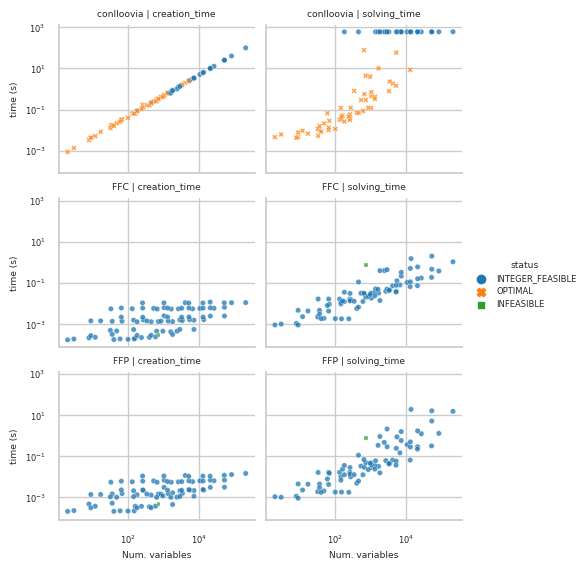

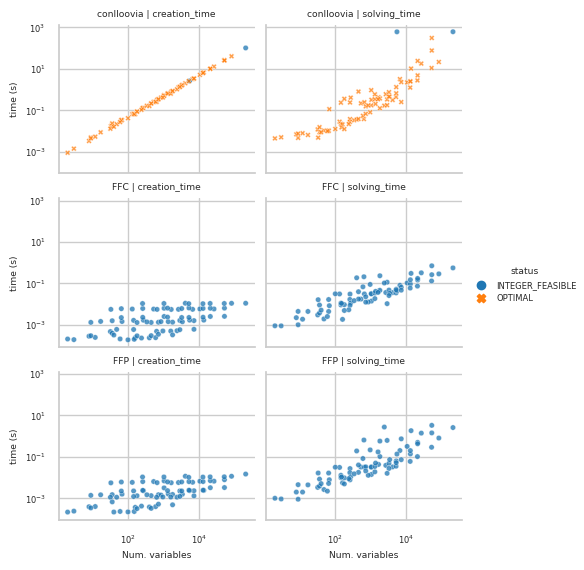

In [7]:
# Both axis using log scales. Notice that negative values not shown

# Plot a scatter plot with the creation and solving times for each mode
with sns.plotting_context("notebook", font_scale=0.55):
    for mode in modes:
        # Select only the rows with the solving and creation times
        df_times = df_stats_long[mode][
            (df_stats_long[mode].variable == "solving_time")
            | (df_stats_long[mode].variable == "creation_time")
        ].rename(columns={"value": "time (s)"})

        g = sns.relplot(
            data=df_times,
            x="num_vars",
            y="time (s)",
            col="variable",
            row="alloc",
            style="status",
            hue="status",
            alpha=0.75,
            height=1.9,
            aspect=1.25,
            s=15,
        )
        g.set(xscale="log")
        g.set(yscale="log")
        g.set_titles(template="{row_name} | {col_name}")
        g.fig.subplots_adjust(top=0.95)
        g.set(xlabel="Num. variables")

        filename = "time_unrestr.png" if mode == "unrestricted" else "time_restr.png"
        g.fig.savefig(FIG_DIR / filename, bbox_inches="tight", dpi=600)

In [8]:
# Look for the maximum solving time
table = Table("mode", "alloc", "row", "max solving time (s)")
for mode in modes:
    for alloc in allocators:
        max_solving_row = df_stats_mode[mode][df_stats_mode[mode].alloc==alloc].solving_time.astype("float").idxmax()
        max_solving_time = df_stats_mode[mode][df_stats_mode[mode].alloc==alloc].solving_time.max()
        table.add_row(mode, alloc, f"{max_solving_row}", f"{max_solving_time:.2f}")

print(table)

┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ mode         ┃ alloc      ┃ row ┃ max solving time (s) ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ unrestricted │ conlloovia │ 0   │ 606.71               │
│ unrestricted │ FFC        │ 108 │ 2.00                 │
│ unrestricted │ FFP        │ 190 │ 18.81                │
│ restricted   │ conlloovia │ 0   │ 605.14               │
│ restricted   │ FFC        │ 108 │ 0.71                 │
│ restricted   │ FFP        │ 189 │ 3.26                 │
└──────────────┴────────────┴─────┴──────────────────────┘

In [9]:
# Plot frac gap for conlloovia
for mode in modes:
    conlloovia_data = df_stats_dict[mode]["conlloovia"]
    if Status.INTEGER_FEASIBLE in set(conlloovia_data.status):
        fig, ax = plt.subplots(figsize=(11, 4))
        ax = conlloovia_data.sort_values(by="num_vars").plot(
            x="num_vars", y="gap_pct", kind="bar", legend=False, ax=ax, color="tab:grey"
        )
        ax.set_ylabel("Gap (%)")
        ax.tick_params(axis="x", labelsize=7)  # setting the font size of x-tick labels
        _ = ax.set_xlabel("Num. variables")
        _ = plt.grid(axis="x")

        plt.savefig(FIG_DIR / f"gap_{mode}.png", bbox_inches="tight", dpi=600)

In [10]:
df_stats_dict["unrestricted"]["conlloovia"].gap_pct.max()

77.99409984029946

# Cost comparison

In [11]:
colors = {
    "FFC": "tab:pink",
    "FFP": "tab:green",
}

# Have the value of each column for the two allocators
df_stats_gr = {}
for mode in modes:
    df_stats_gr[mode] = df_stats_mode[mode].pivot(
        index=["exp", "num_vars"], columns=["alloc"]
    )

In [12]:
# Print the number of experiments with each status for each allocator
for mode in modes:
    print(f"Status for the {mode} experiments")
    print(df_stats_gr[mode].status.apply(pd.value_counts).fillna(0))

Status for the unrestricted experiments

alloc              FFC   FFP  conlloovia
INFEASIBLE         1.0   1.0         0.0
INTEGER_FEASIBLE  80.0  80.0        29.0
OPTIMAL            0.0   0.0        52.0

Status for the restricted experiments

alloc              FFC   FFP  conlloovia
INTEGER_FEASIBLE  81.0  81.0           2
OPTIMAL            0.0   0.0          79

In [13]:
df_stats_gr[mode].reset_index()[["num_vars", "cost", "status"]]

num_vars  cost                             status                    \
alloc            FFC   FFP conlloovia               FFC               FFP   
0       205600  8.32  8.08       8.08  INTEGER_FEASIBLE  INTEGER_FEASIBLE   
1        52000  8.96  8.48       8.44  INTEGER_FEASIBLE  INTEGER_FEASIBLE   
2        26400  8.96  8.48       8.48  INTEGER_FEASIBLE  INTEGER_FEASIBLE   
3        82240  4.16  4.16       4.08  INTEGER_FEASIBLE  INTEGER_FEASIBLE   
4        20800  3.84  3.76       3.68  INTEGER_FEASIBLE  INTEGER_FEASIBLE   
..         ...   ...   ...        ...               ...               ...   
76          60  0.16  0.16       0.16  INTEGER_FEASIBLE  INTEGER_FEASIBLE   
77          40  0.32  0.32       0.32  INTEGER_FEASIBLE  INTEGER_FEASIBLE   
78           9  1.28  1.28       1.28  INTEGER_FEASIBLE  INTEGER_FEASIBLE   
79           3  0.04  0.04       0.04  INTEGER_FEASIBLE  INTEGER_FEASIBLE   
80           2  0.64  0.64       0.64  INTEGER_FEASIBLE  INTEGER_FEASIBLE   

                         
alloc        conlloovia  
0      INTEGER_FEASIBLE  
1               OPTIMAL  
2               OPTIMAL  
3               OPTIMAL  
4               OPTIMAL  
..                  ...  
76              OPTIMAL  
77              OPTIMAL  
78              OPTIMAL  
79              OPTIMAL  
80              OPTIMAL  

[81 rows x 7 columns]

'unrestricted'

,num_vars,FFC %,FFP %
count,81.000000,81.000000,81.000000
mean,8467.407407,95.231480,95.966348
std,26082.483239,165.896099,198.971270
min,2.000000,0.000000,0.000000
25%,144.000000,0.000000,0.000000
50%,850.000000,28.007714,27.815151
75%,5140.000000,99.427695,99.576088
max,205600.000000,1076.207477,1506.362315


'restricted'

,num_vars,FFC %,FFP %
count,81.000000,81.000000,8.100000e+01
mean,8467.407407,7.939686,4.358848e+01
std,26082.483239,16.133078,1.309860e+02
min,2.000000,0.000000,-2.220446e-14
25%,144.000000,0.000000,0.000000e+00
50%,850.000000,0.000000,2.220446e-14
75%,5140.000000,6.666667,1.898734e+01
max,205600.000000,77.777778,1.000000e+03


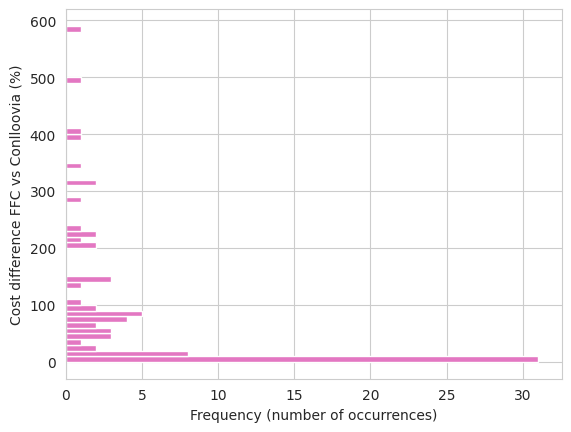

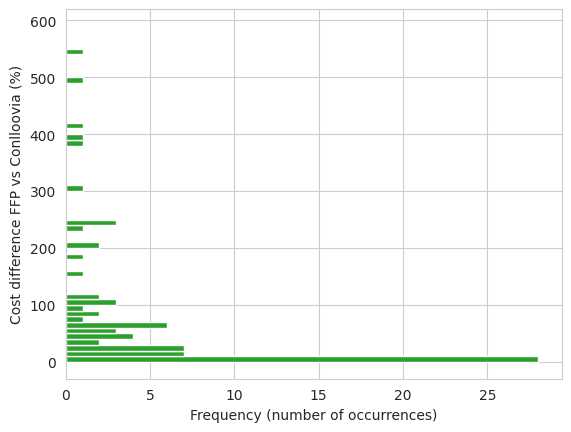

<Figure size 640x480 with 0 Axes>

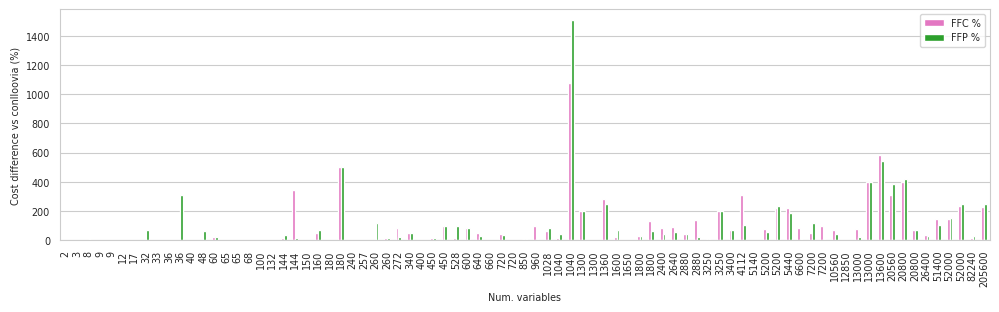

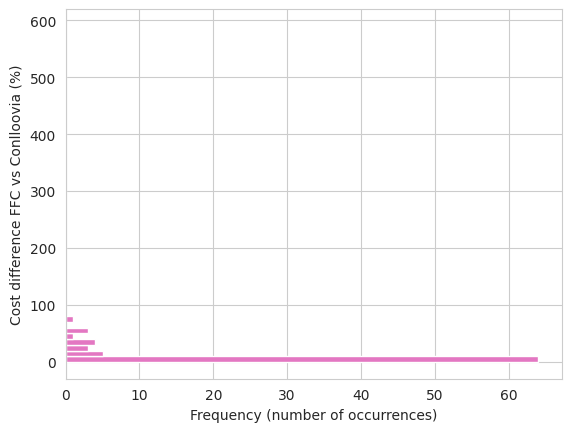

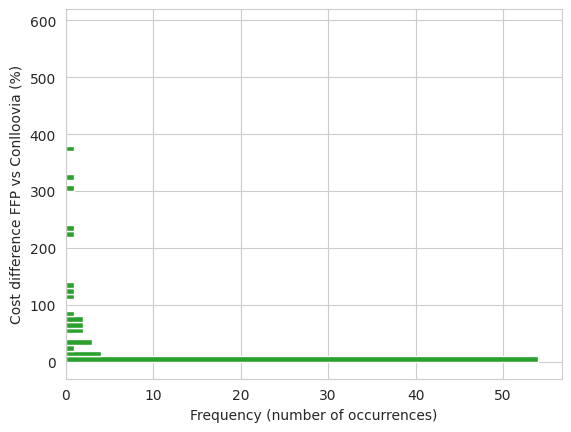

<Figure size 640x480 with 0 Axes>

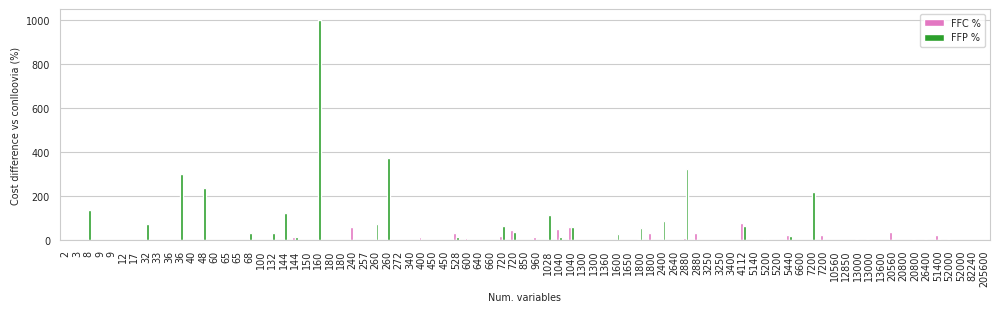

In [19]:
# Plot the difference with conlloovia of all allocators, both in absolute and
# percentage terms. Show the difference only in the experiments where the
# heuristic finds a solution
df_cost_diff_modes = pd.DataFrame()
df_cost_diff_dict = {}
for mode in modes:
    df_cost_diff = df_stats_gr[mode].reset_index()[["num_vars", "cost", "status"]].copy()
    df_cost_diff.columns = ["num_vars", "FFC", "FFP", "conlloovia", "status_FFC", "status_FFP", "status_conlloovia"]

    for allocator in allocators:
        if allocator == "conlloovia":
            continue

        # Compute the data (pct_change and diff)
        df_cost_diff[f"{allocator} %"] = (
            df_cost_diff[["conlloovia", allocator]].pct_change(axis=1)[allocator] * 100
        )
        df_cost_diff[f"diff_{allocator}"] = (
            df_cost_diff[allocator] - df_cost_diff["conlloovia"]
        )

        # If the heuristic didn't find a solution, set the difference and the pct to 0
        df_cost_diff.loc[df_cost_diff[f"status_{allocator}"] != "INTEGER_FEASIBLE", f"{allocator} %"] = 0
        df_cost_diff.loc[df_cost_diff[f"status_{allocator}"] != "INTEGER_FEASIBLE", f"diff_{allocator}"] = 0

    display(mode, df_cost_diff.describe())
    plt.figure()
    df_cost_diff["FFC %"].plot.hist(bins=range(0, 600, 10), color=colors["FFC"], orientation="horizontal")
    plt.ylabel("Cost difference FFC vs Conlloovia (%)")
    plt.xlabel("Frequency (number of occurrences)")
    file_name = "hist_ffc_unrestr" if mode == "unrestricted" else "hist_ffc_restr"
    plt.savefig(FIG_DIR / file_name, bbox_inches="tight", dpi=600)

    plt.figure()
    df_cost_diff["FFP %"].plot.hist(bins=range(0, 600, 10), color=colors["FFP"], orientation="horizontal")
    plt.ylabel("Cost difference FFP vs Conlloovia (%)")
    plt.xlabel("Frequency (number of occurrences)")
    file_name = "hist_ffp_unrestr" if mode == "unrestricted" else "hist_ffp_restr"
    plt.savefig(FIG_DIR / file_name, bbox_inches="tight", dpi=600)

    df_cost_diff["mode"] = mode
    df_cost_diff_modes = pd.concat([df_cost_diff_modes, df_cost_diff])
    df_cost_diff_dict[mode] = df_cost_diff

    # Plot the percentage change
    fig = plt.figure()
    ax = (
        df_cost_diff[["num_vars", "FFC %", "FFP %"]]
        .sort_values(by="num_vars")
        .plot(x="num_vars", kind="bar", figsize=(12, 3),
              color=[colors["FFC"], colors["FFP"]]
              )
    )
    plt.grid(axis="x")
    plt.xlabel("Num. variables", fontsize="x-small")
    plt.ylabel("Cost difference vs conlloovia (%)", fontsize="x-small")
    ax.xaxis.set_tick_params(labelsize="x-small")
    ax.yaxis.set_tick_params(labelsize="x-small")
    plt.legend(fontsize="x-small")

    file_name = "cost_unrestr" if mode == "unrestricted" else "cost_restr"
    plt.savefig(FIG_DIR / file_name, bbox_inches="tight", dpi=600)

In [20]:
df_cost_diff[["FFC %", "FFP %"]].describe()

,FFC %,FFP %
count,81.000000,8.100000e+01
mean,7.939686,4.358848e+01
std,16.133078,1.309860e+02
min,0.000000,-2.220446e-14
25%,0.000000,0.000000e+00
50%,0.000000,2.220446e-14
75%,6.666667,1.898734e+01
max,77.777778,1.000000e+03
